In [46]:
import math
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal, interpolate
from sklearn.metrics import r2_score, mean_squared_error

from data_loader import load_pickle, unpack_data

In [89]:
datasets = []
for i in range(1, 10):
    datasets.append(load_pickle(i))

In [117]:
def compute_distances(Sxx, f_acc, hr, default_val):
    distances = []

    for t in range(Sxx.shape[1]):
        
        # check whether there is a relevant accelerometer frequency at time t
        if sum(Sxx[:, t]) == 0:
            distances.append(default_val)
            continue
        
        # find hr_index that corresponds to a frequency in f_acc that is closest to hr[t]
        hr_index = np.searchsorted(f_acc, hr[t])
        
        # find the distances of all relevant accelerometer freqs to the heart rate freq at time t
        idx_distances_at_t = abs(np.where(Sxx[:, t] == 1)[0] - hr_index)
        distances_at_t = idx_distances_at_t * (f_acc[1] - f_acc[0])
        
        # save the minimum distance at time t
        distances.append(min(distances_at_t))

    return np.array(distances)

<ipython-input-120-bdb677f23d55>:39: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(t_ppg, f_ppg, Sxx_ppg_clipped, shading='flat')
No handles with labels found to put in legend.


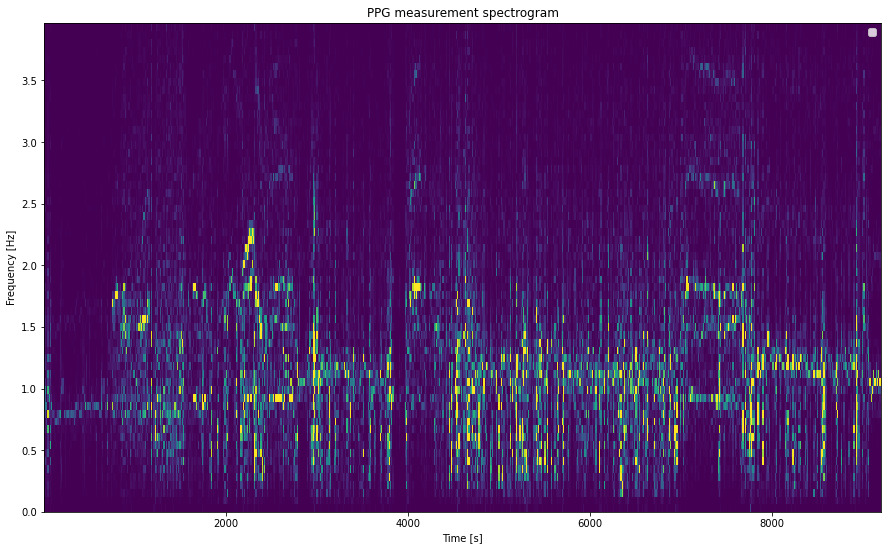

<ipython-input-120-bdb677f23d55>:55: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(t_acc, f_acc, Sxx_acc_above_threshold, shading='flat')
<ipython-input-120-bdb677f23d55>:39: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(t_ppg, f_ppg, Sxx_ppg_clipped, shading='flat')
No handles with labels found to put in legend.


RMSE: 0.3688434968704137


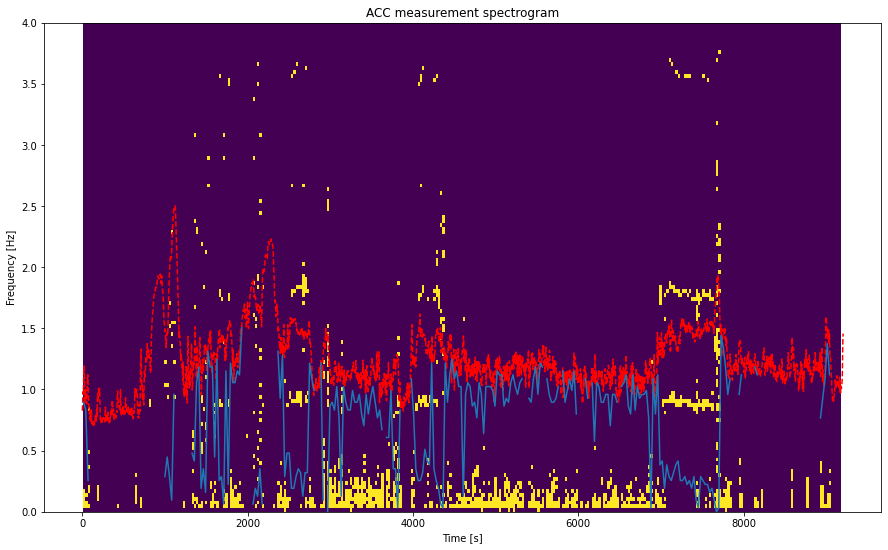

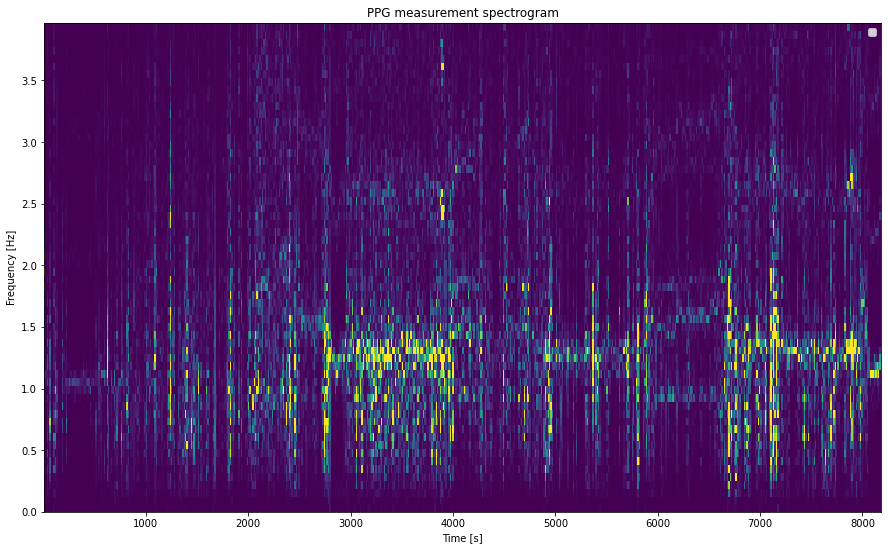

<ipython-input-120-bdb677f23d55>:55: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(t_acc, f_acc, Sxx_acc_above_threshold, shading='flat')
<ipython-input-120-bdb677f23d55>:39: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(t_ppg, f_ppg, Sxx_ppg_clipped, shading='flat')
No handles with labels found to put in legend.


RMSE: 0.404799049645769


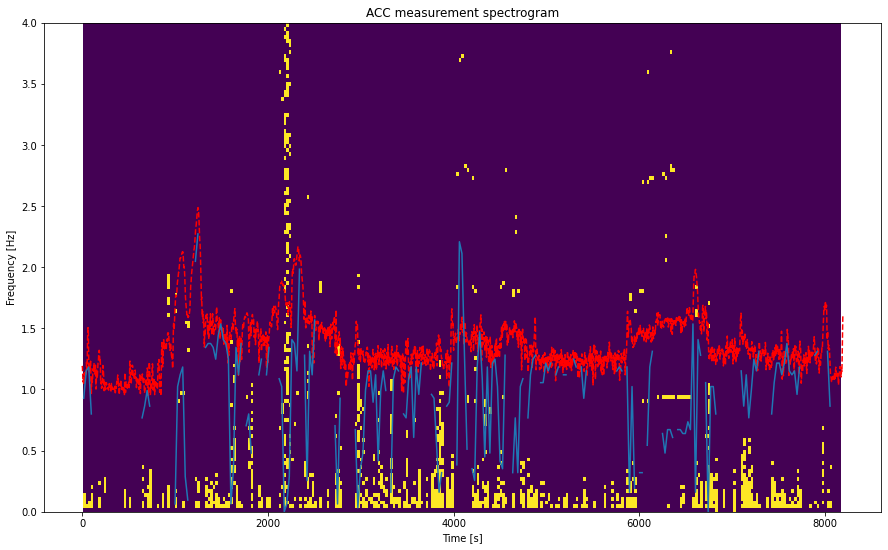

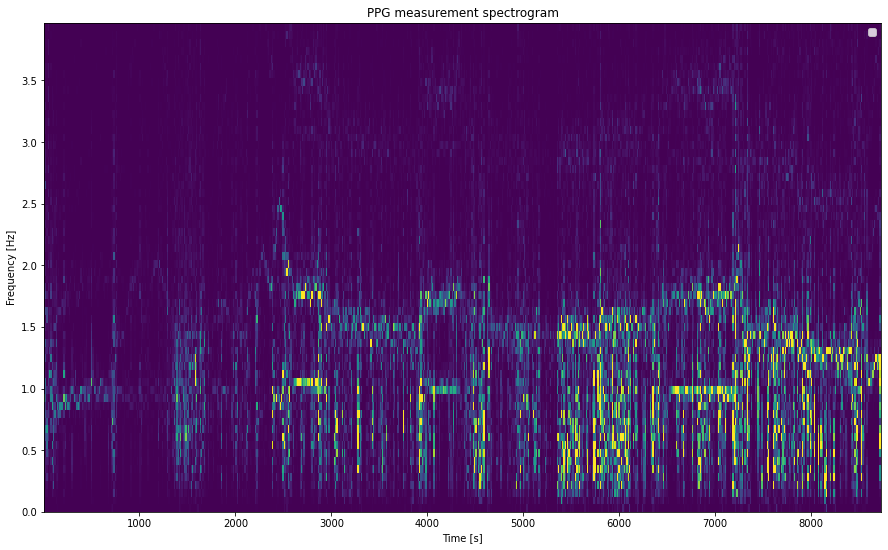

<ipython-input-120-bdb677f23d55>:55: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(t_acc, f_acc, Sxx_acc_above_threshold, shading='flat')
<ipython-input-120-bdb677f23d55>:39: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(t_ppg, f_ppg, Sxx_ppg_clipped, shading='flat')
No handles with labels found to put in legend.


RMSE: 0.5662615653241578


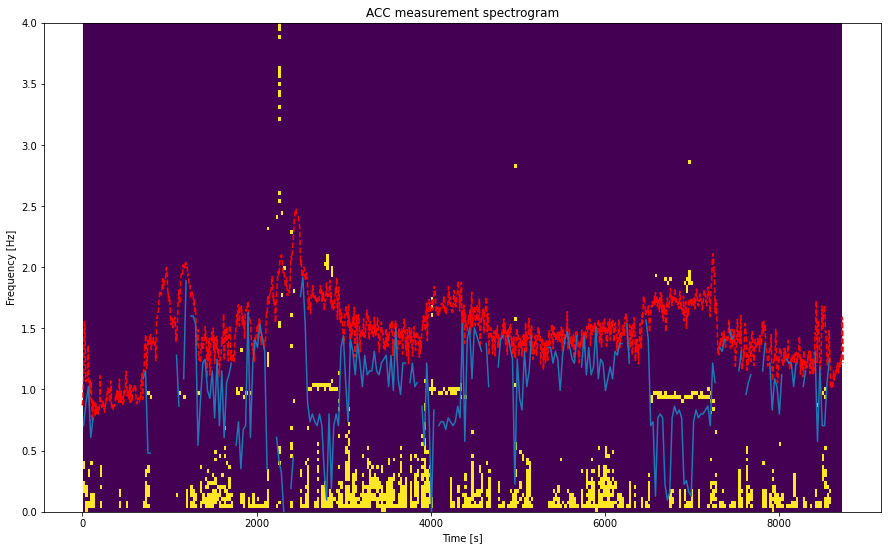

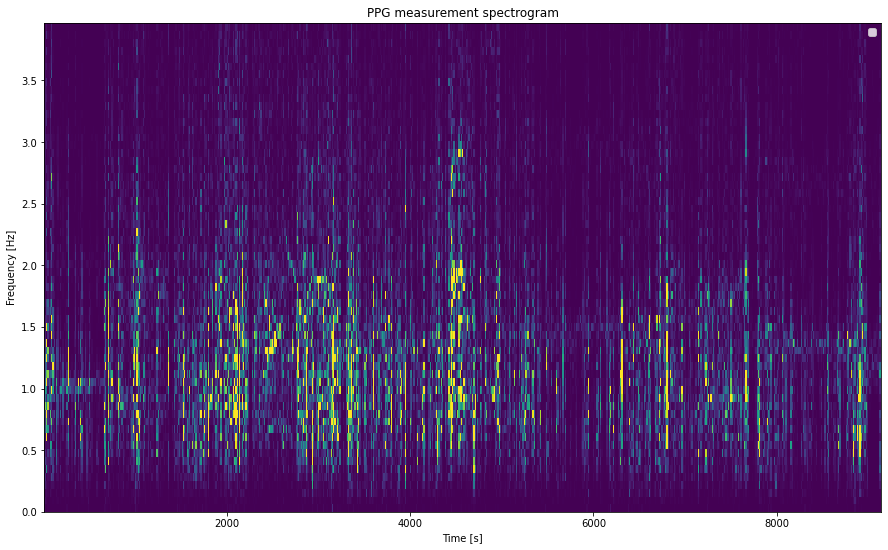

<ipython-input-120-bdb677f23d55>:55: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(t_acc, f_acc, Sxx_acc_above_threshold, shading='flat')
<ipython-input-120-bdb677f23d55>:39: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(t_ppg, f_ppg, Sxx_ppg_clipped, shading='flat')
No handles with labels found to put in legend.


RMSE: 0.5361344118750052


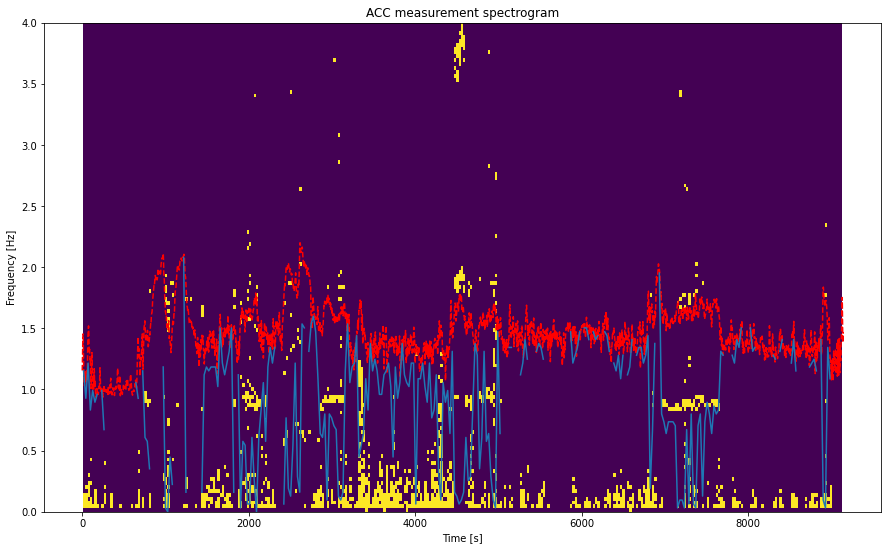

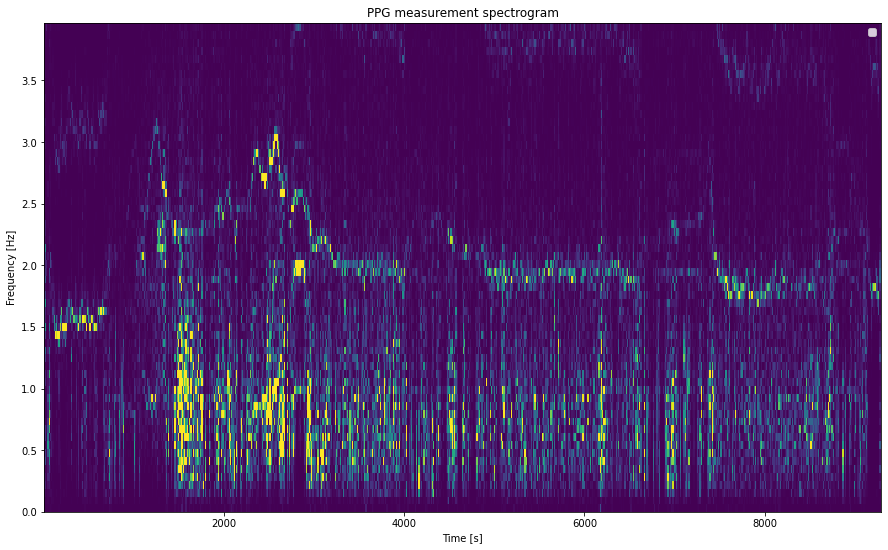

<ipython-input-120-bdb677f23d55>:55: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(t_acc, f_acc, Sxx_acc_above_threshold, shading='flat')
<ipython-input-120-bdb677f23d55>:39: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(t_ppg, f_ppg, Sxx_ppg_clipped, shading='flat')
No handles with labels found to put in legend.


RMSE: 1.13712991195958


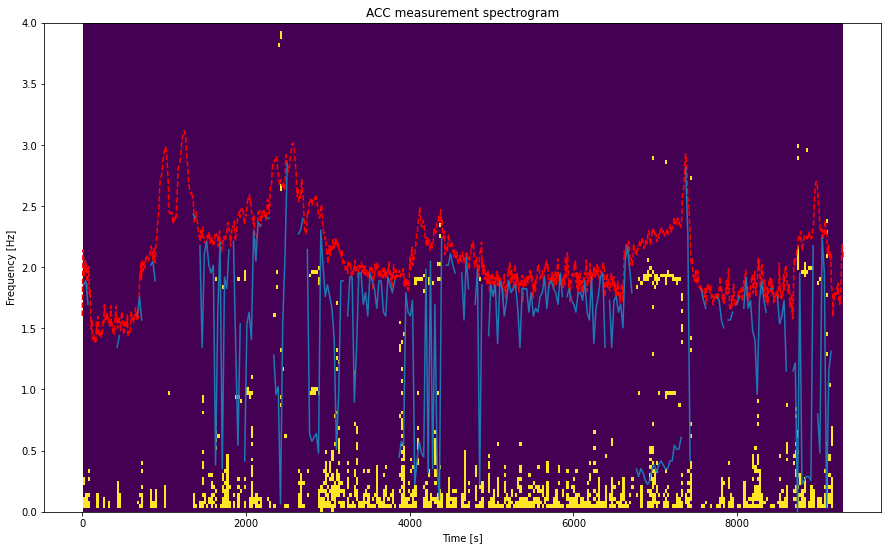

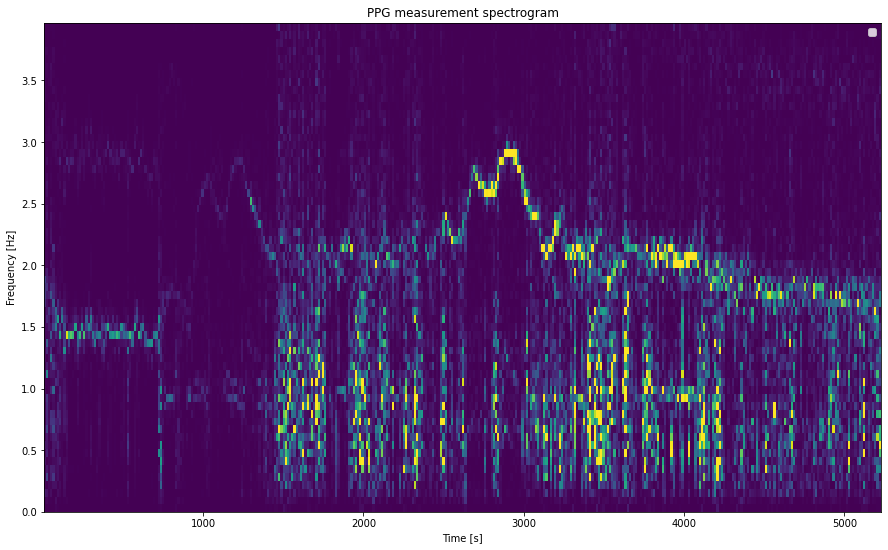

<ipython-input-120-bdb677f23d55>:55: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(t_acc, f_acc, Sxx_acc_above_threshold, shading='flat')
<ipython-input-120-bdb677f23d55>:39: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(t_ppg, f_ppg, Sxx_ppg_clipped, shading='flat')
No handles with labels found to put in legend.


RMSE: 0.7838135354571485


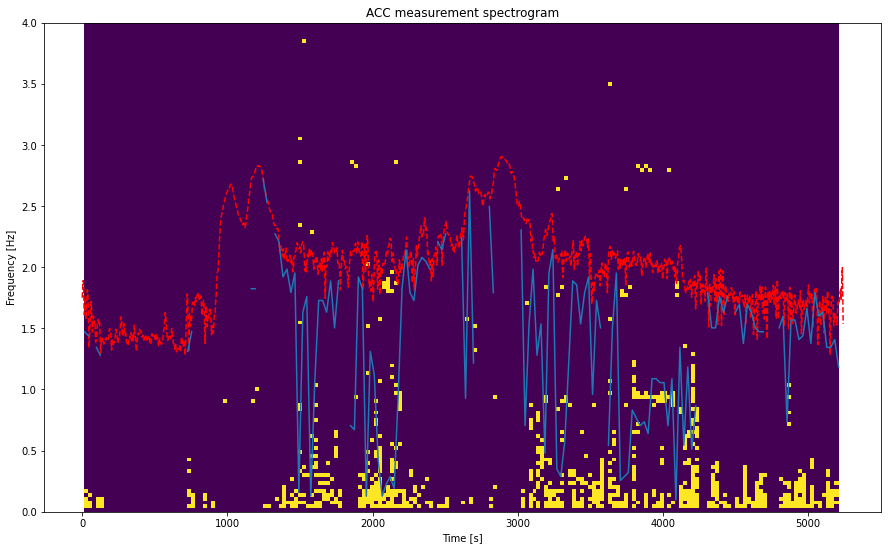

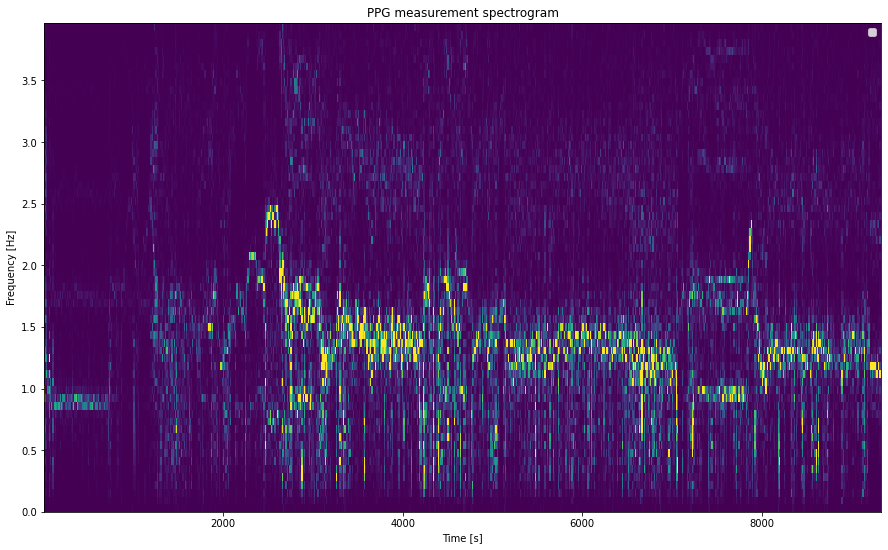

<ipython-input-120-bdb677f23d55>:55: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(t_acc, f_acc, Sxx_acc_above_threshold, shading='flat')
<ipython-input-120-bdb677f23d55>:39: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(t_ppg, f_ppg, Sxx_ppg_clipped, shading='flat')
No handles with labels found to put in legend.


RMSE: 0.33764670803911023


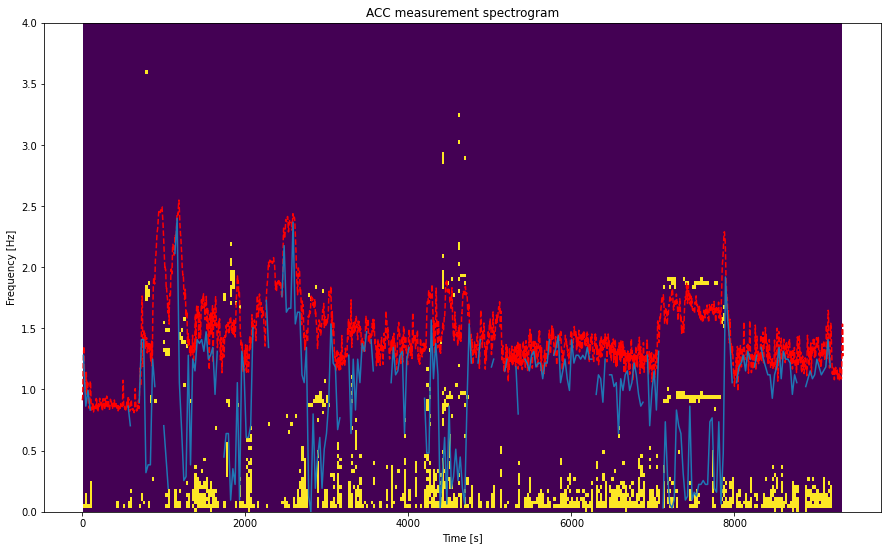

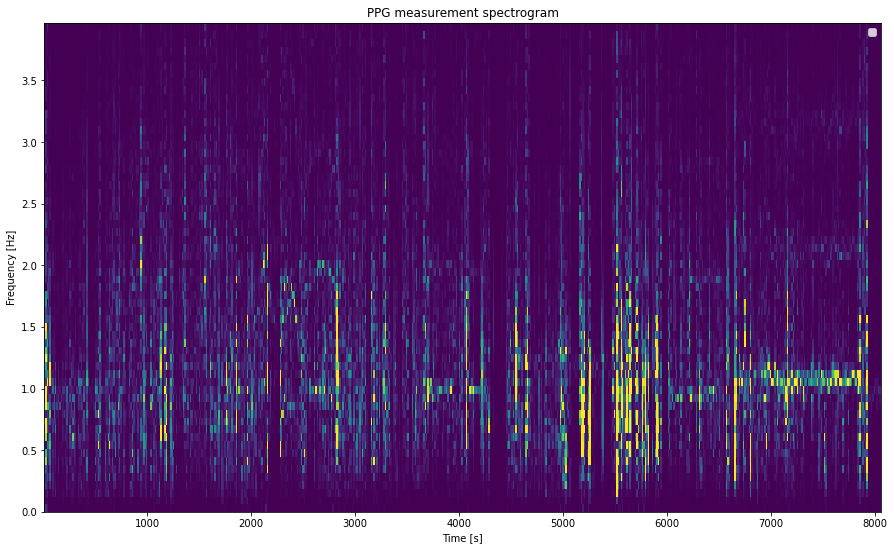

<ipython-input-120-bdb677f23d55>:55: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(t_acc, f_acc, Sxx_acc_above_threshold, shading='flat')
<ipython-input-120-bdb677f23d55>:39: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(t_ppg, f_ppg, Sxx_ppg_clipped, shading='flat')
No handles with labels found to put in legend.


RMSE: 0.4251447868758379


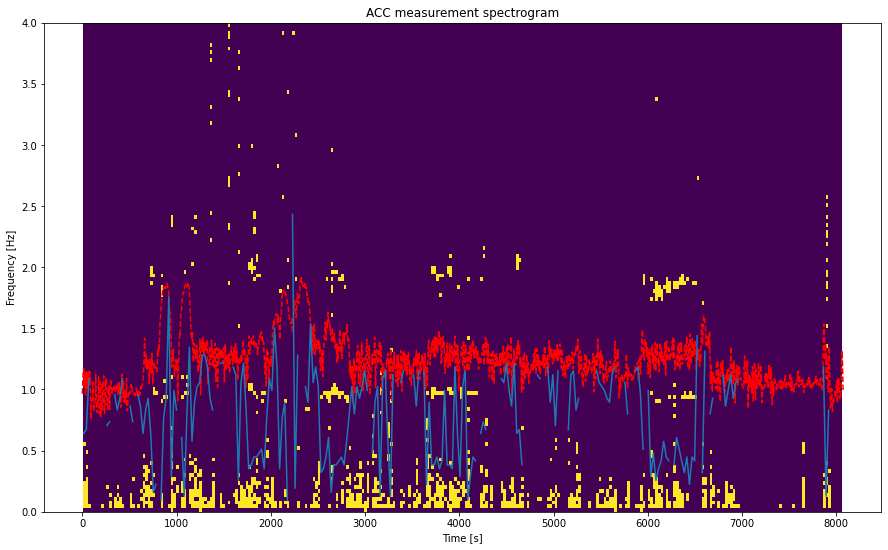

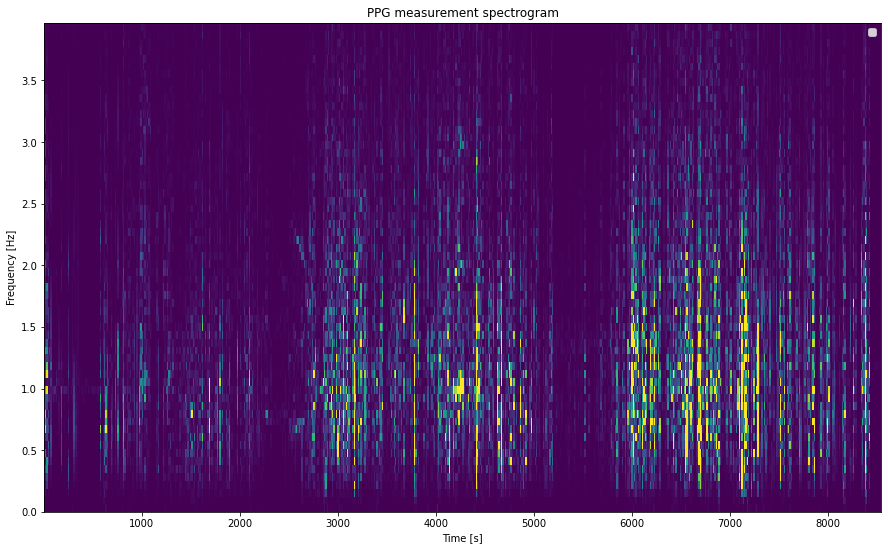

<ipython-input-120-bdb677f23d55>:55: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(t_acc, f_acc, Sxx_acc_above_threshold, shading='flat')


RMSE: 0.6368292344217105


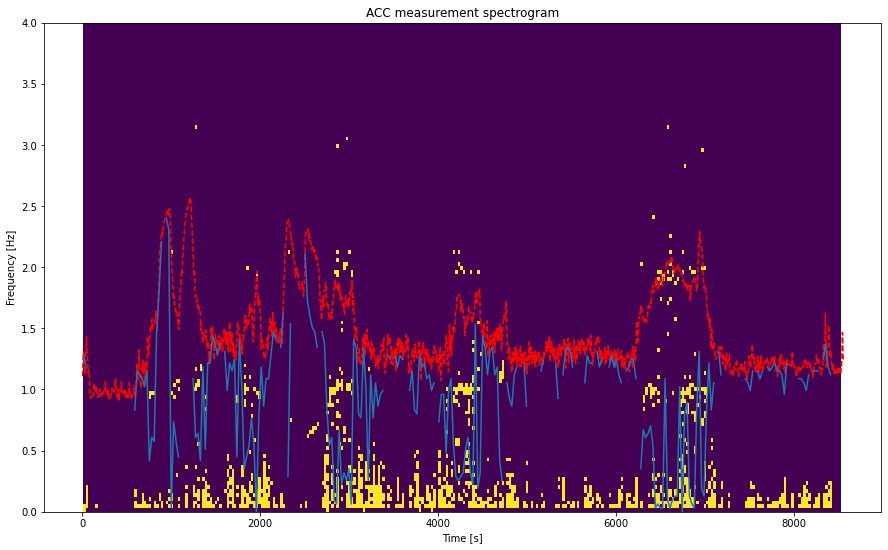

In [120]:
acc_threshold_percentile = 97
distances_default_value = np.nan

for dataset in datasets:

    ppg, acc, hr = unpack_data(dataset)
    ppg = ppg[:, 0]
    acc = acc[:, 0]

    hr_hz = hr / 60
    hr_timestamps = np.arange(0, len(hr) * 2, 2)
    hr_hz_interpolation = interpolate.interp1d(hr_timestamps, hr_hz)

    fs_ppg = 64
    fs_acc = 32
    nperseg_ppg = 1000
    noverlap = None
    
    ### create spectrograms
    f_ppg, t_ppg, Sxx_ppg = signal.spectrogram(ppg, fs_ppg, nperseg=nperseg_ppg, noverlap=noverlap)
    f_acc, t_acc, Sxx_acc = signal.spectrogram(acc, fs_acc, nperseg=nperseg_ppg, noverlap=noverlap)
    
    ### keep only frequencies of interest
    fmin = 0 # Hz
    fmax = 4 # Hz
    freq_slice_ppg = np.where((f_ppg >= fmin) & (f_ppg <= fmax))
    freq_slice_acc = np.where((f_acc >= fmin) & (f_acc <= fmax))
    f_ppg = f_ppg[freq_slice_ppg]
    f_acc = f_acc[freq_slice_acc]
    Sxx_ppg = Sxx_ppg[freq_slice_ppg,:][0]
    Sxx_acc = Sxx_acc[freq_slice_acc,:][0]
    
    ### clip spectrograms
    Sxx_acc_clipped = np.clip(Sxx_acc, 0, np.percentile(Sxx_acc.flatten(), 99))
    Sxx_ppg_clipped = np.clip(Sxx_ppg, 0, np.percentile(Sxx_ppg.flatten(), 99))

    ### plot ppg spectrogram
    plt.figure(figsize=(15, 9))
    plt.pcolormesh(t_ppg, f_ppg, Sxx_ppg_clipped, shading='flat')
    plt.title('PPG measurement spectrogram')
    plt.ylabel('Frequency [Hz]')
    plt.xlabel('Time [s]')
    
    ### plot heart rate
    ppg_estimate = f_ppg[np.argmax(Sxx_ppg, axis=0)]
    #plt.plot(hr_timestamps, hr_hz, 'r--', label='heart rate')
    #plt.plot(t_ppg, ppg_estimate, 'g--', label='ppg heart rate estimate')
    plt.legend()
    plt.show()
    
    ### plot acc spectrogram
    plt.figure(figsize=(15, 9))
    #plt.pcolormesh(t_acc, f_acc, Sxx_acc_clipped, shading='flat')
    Sxx_acc_above_threshold = (Sxx_acc > np.percentile(Sxx_acc.flatten(), acc_threshold_percentile)).astype(int)
    plt.pcolormesh(t_acc, f_acc, Sxx_acc_above_threshold, shading='flat')
    plt.title('ACC measurement spectrogram')
    plt.plot(hr_timestamps, hr_hz, 'r--', label='heart rate')
    plt.ylabel('Frequency [Hz]')
    plt.xlabel('Time [s]')
    
    ### plot distance metric
    hr_hz_at_acc_timestamps = hr_hz_interpolation(t_acc)
    distances = compute_distances(Sxx_acc_above_threshold, f_acc, hr_hz_at_acc_timestamps, distances_default_value)
    plt.plot(t_acc, distances)
    
    print('RMSE:', math.sqrt(mean_squared_error(hr_hz_interpolation(t_ppg), ppg_estimate)))


In [102]:
f_acc

array([0.512, 0.544, 0.576, 0.608, 0.64 , 0.672, 0.704, 0.736, 0.768,
       0.8  , 0.832, 0.864, 0.896, 0.928, 0.96 , 0.992, 1.024, 1.056,
       1.088, 1.12 , 1.152, 1.184, 1.216, 1.248, 1.28 , 1.312, 1.344,
       1.376, 1.408, 1.44 , 1.472, 1.504, 1.536, 1.568, 1.6  , 1.632,
       1.664, 1.696, 1.728, 1.76 , 1.792, 1.824, 1.856, 1.888, 1.92 ,
       1.952, 1.984, 2.016, 2.048, 2.08 , 2.112, 2.144, 2.176, 2.208,
       2.24 , 2.272, 2.304, 2.336, 2.368, 2.4  , 2.432, 2.464, 2.496,
       2.528, 2.56 , 2.592, 2.624, 2.656, 2.688, 2.72 , 2.752, 2.784,
       2.816, 2.848, 2.88 , 2.912, 2.944, 2.976, 3.008, 3.04 , 3.072,
       3.104, 3.136, 3.168, 3.2  , 3.232, 3.264, 3.296, 3.328, 3.36 ,
       3.392, 3.424, 3.456, 3.488, 3.52 , 3.552, 3.584, 3.616, 3.648,
       3.68 , 3.712, 3.744, 3.776, 3.808, 3.84 , 3.872, 3.904, 3.936,
       3.968, 4.   ])